In [1]:
import os
import random
import time
import glob
import shutil
import warnings

import cv2
import scipy
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import albumentations as A
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from albumentations.pytorch import ToTensor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid, save_image


%matplotlib inline
warnings.filterwarnings('ignore', category=FutureWarning)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Settings

In [2]:
config = {'DataLoader': {'batch_size': 64,
                         'shuffle': True},
          'Generator': {'latent_dim': 120,
                        'embed_dim': 32,
                        'ch': 64,
                        'num_classes': 120,
                        'use_attn': True},
          'Discriminator': {'ch': 64,
                            'num_classes': 120,
                            'use_attn': True},
          'sample_latents': {'latent_dim': 120,
                             'num_classes': 120},
          'num_iterations': 50000,
          'decay_start_iteration': 50000,
          'd_steps': 1,
          'lr_G': 2e-4,
          'lr_D': 4e-4,
          'betas': (0.0, 0.999),
          'margin': 1.0,
          'gamma': 0.1,
          'ema': 0.999,
          'seed': 42}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(config['seed'])

# Data Processing

## Load Data

In [4]:
root_images = '../input/all-dogs/all-dogs/'
root_annots = '../input/annotation/Annotation/'

In [5]:
all_files = os.listdir(root_images)

In [6]:
breeds = glob.glob(root_annots+'*')
annotations = []
for breed in breeds:
    annotations += glob.glob(breed+'/*')

In [7]:
breed_map = {}
for annotation in annotations:
    breed = annotation.split('/')[-2]
    index = breed.split('-')[0]
    breed_map.setdefault(index, breed)

In [8]:
all_labels = [breed_map[file.split('_')[0]] for file in all_files]
le = LabelEncoder()
all_labels = le.fit_transform(all_labels)

In [9]:
def load_bbox(file):
    file = str(breed_map[file.split('_')[0]]) + '/' + str(file.split('.')[0])
    path = os.path.join(root_annots, file)
    tree = ET.parse(path)
    root = tree.getroot()
    objects = root.findall('object')
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
    
    return (xmin, ymin, xmax, ymax)

In [10]:
all_bboxes = [load_bbox(file) for file in all_files]

In [11]:
print('Total files       : {}'.format(len(all_files)))
print('Total labels      : {}'.format(len(all_labels)))
print('Total bboxes      : {}'.format(len(all_bboxes)))
print('Total annotations : {}'.format(len(annotations)))
print('Total classes     : {}'.format(len(le.classes_)))

Total files       : 20579
Total labels      : 20579
Total bboxes      : 20579
Total annotations : 20580
Total classes     : 120


In [12]:
# make square bounding boxes of original ones,
# to keep a dog's aspect ratio.

def get_resized_bbox(height, width, bbox):
    xmin, ymin, xmax, ymax = bbox
    xlen = xmax - xmin
    ylen = ymax - ymin
    
    if xlen > ylen:
        diff = xlen - ylen
        min_pad = min(ymin, diff//2)
        max_pad = min(height-ymax, diff-min_pad)
        ymin = ymin - min_pad
        ymax = ymax + max_pad

    elif ylen > xlen:
        diff = ylen - xlen
        min_pad = min(xmin, diff//2)
        max_pad = min(width-xmax, diff-min_pad)
        xmin = xmin - min_pad
        xmax = xmax + max_pad
    
    return xmin, ymin, xmax, ymax

In [13]:
resized_bboxes = []
for file, bbox in zip(all_files, all_bboxes):
    img = Image.open(os.path.join(root_images, file))
    width, height = img.size
    xmin, ymin, xmax, ymax = get_resized_bbox(height, width, bbox)
    resized_bboxes.append((xmin, ymin, xmax, ymax))

In [14]:
# crop by square bounding box -> resize and normalize.
# cv2.INTER_AREA is better than others.

def load_bboxcrop_resized_image(file, bbox):
    img = cv2.imread(os.path.join(root_images, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    xmin, ymin, xmax, ymax = bbox
    img = img[ymin:ymax,xmin:xmax]

    transform = A.Compose([A.Resize(64, 64, interpolation=cv2.INTER_AREA),
                           A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    img = transform(image=img)['image']
    
    return img

In [15]:
all_images = [load_bboxcrop_resized_image(f, b) for f, b in zip(all_files, resized_bboxes)]
all_images = np.array(all_images)

In [16]:
class DogDataset(Dataset):
    def __init__(self, images, labels):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = A.Compose([A.HorizontalFlip(p=0.5), ToTensor()])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img, label = self.images[idx], self.labels[idx]
        img = self.transform(image=img)['image']
        label = torch.as_tensor(label, dtype=torch.long)

        return img, label

In [17]:
# adding uniform noise works well.

def get_dataiterator(images, labels, dataloader_params, device='cpu'):
    train_dataset = DogDataset(images, labels)
    train_dataloader = DataLoader(train_dataset, **dataloader_params)

    while True:
        for imgs, labels in train_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            imgs += (1.0 / 128.0) * torch.rand_like(imgs)

            yield imgs, labels

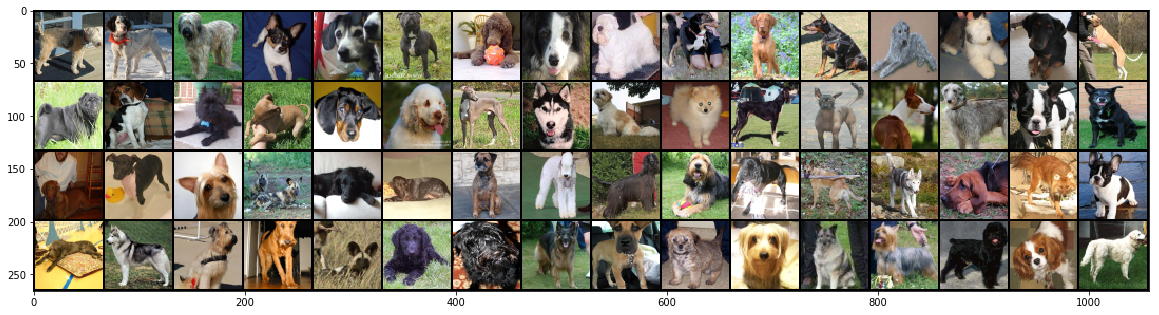

In [18]:
train_dataiterator = get_dataiterator(all_images, all_labels, config['DataLoader'])

imgs, _ = train_dataiterator.__next__()
imgs = (imgs + 1) / 2
imgs = make_grid(imgs, nrow=16, normalize=False)
imgs = imgs.mul_(255).add_(0.5).clamp_(0, 255).permute(1,2,0).to(torch.uint8).numpy()

plt.figure(figsize=(20,10))
plt.imshow(imgs);

# Models

In [19]:
# Attention slightly works.

class Attention(nn.Module):
    def __init__(self, channels, reduction_attn=8, reduction_sc=2):
        super().__init__()
        self.channles_attn = channels // reduction_attn
        self.channels_sc = channels // reduction_sc
        
        self.conv_query = spectral_norm(nn.Conv2d(channels, self.channles_attn, kernel_size=1, bias=False))
        self.conv_key = spectral_norm(nn.Conv2d(channels, self.channles_attn, kernel_size=1, bias=False))
        self.conv_value = spectral_norm(nn.Conv2d(channels, self.channels_sc, kernel_size=1, bias=False))
        self.conv_attn = spectral_norm(nn.Conv2d(self.channels_sc, channels, kernel_size=1, bias=False))
        self.gamma = nn.Parameter(torch.zeros(1))
        
        nn.init.orthogonal_(self.conv_query.weight.data)
        nn.init.orthogonal_(self.conv_key.weight.data)
        nn.init.orthogonal_(self.conv_value.weight.data)
        nn.init.orthogonal_(self.conv_attn.weight.data)

    def forward(self, x):
        batch, _, h, w = x.size()
        
        proj_query = self.conv_query(x).view(batch, self.channles_attn, -1)
        proj_key = F.max_pool2d(self.conv_key(x), 2).view(batch, self.channles_attn, -1)
        
        attn = torch.bmm(proj_key.permute(0,2,1), proj_query)
        attn = F.softmax(attn, dim=1)
        
        proj_value = F.max_pool2d(self.conv_value(x), 2).view(batch, self.channels_sc, -1)
        attn = torch.bmm(proj_value, attn)
        attn = attn.view(batch, self.channels_sc, h, w)
        attn = self.conv_attn(attn)
        
        out = self.gamma * attn + x
        
        return out

## Generator

In [20]:
# using label information works well.
# As for generator, it is realized by conditional batch normalization.  

class CBN2d(nn.Module):
    def __init__(self, num_features, num_conditions):
        super().__init__()
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.embed = spectral_norm(nn.Conv2d(num_conditions, num_features*2, kernel_size=1, bias=False))
        
        nn.init.orthogonal_(self.embed.weight.data)

    def forward(self, x, y):
        out = self.bn(x)
        embed = self.embed(y.unsqueeze(2).unsqueeze(3))
        gamma, beta = embed.chunk(2, dim=1)
        out = (1.0 + gamma) * out + beta 

        return out

In [21]:
# residual block improves convergence speed and generated image's quality.
# nearest upsampling is better than others.

class GBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conditions, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.learnable_sc = in_channels != out_channels or upsample
        
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False))
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False))
        self.cbn1 = CBN2d(in_channels, num_conditions)
        self.cbn2 = CBN2d(out_channels, num_conditions)
        if self.learnable_sc:
            self.conv_sc = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False))
        self.relu = nn.ReLU()

        nn.init.orthogonal_(self.conv1.weight.data)
        nn.init.orthogonal_(self.conv2.weight.data)
        if self.learnable_sc:
            nn.init.orthogonal_(self.conv_sc.weight.data)
    
    def _upsample_conv(self, x, conv):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = conv(x)
        
        return x
    
    def _residual(self, x, y):
        x = self.relu(self.cbn1(x, y))
        x = self._upsample_conv(x, self.conv1) if self.upsample else self.conv1(x)
        x = self.relu(self.cbn2(x, y))
        x = self.conv2(x)
        
        return x
    
    def _shortcut(self, x):
        if self.learnable_sc:
            x = self._upsample_conv(x, self.conv_sc) if self.upsample else self.conv_sc(x)
            
        return x
    
    def forward(self, x, y):
        return self._shortcut(x) + self._residual(x, y)

In [22]:
# shared embedding of class labels, and hierarchical latent noise, work well.
# this architecture is the same as BigGAN except for channel size.

class Generator(nn.Module):
    def __init__(self, latent_dim, ch, num_classes, embed_dim, use_attn=False):
        super().__init__()
        self.latent_dim = latent_dim
        self.ch = ch
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.use_attn = use_attn
        self.num_chunk = 5
        num_latents = self.__get_num_latents()
        
        self.embed = nn.Embedding(num_classes, embed_dim)
        self.fc = spectral_norm(nn.Linear(num_latents[0], ch*8*4*4, bias=False))
        self.block1 = GBlock(ch*8, ch*8, num_latents[1], upsample=True)
        self.block2 = GBlock(ch*8, ch*4, num_latents[2], upsample=True)
        self.block3 = GBlock(ch*4, ch*2, num_latents[3], upsample=True)
        if use_attn:
            self.attn = Attention(ch*2)
        self.block4 = GBlock(ch*2, ch, num_latents[4], upsample=True)
        self.bn = nn.BatchNorm2d(ch)
        self.relu = nn.ReLU()
        self.conv_last = spectral_norm(nn.Conv2d(ch, 3, kernel_size=3, padding=1, bias=False))
        self.tanh = nn.Tanh()
        
        nn.init.orthogonal_(self.embed.weight.data)
        nn.init.orthogonal_(self.fc.weight.data)
        nn.init.orthogonal_(self.conv_last.weight.data)
        nn.init.constant_(self.bn.weight.data, 1.0)
        nn.init.constant_(self.bn.bias.data, 0.0)
    
    def __get_num_latents(self):
        xs = torch.empty(self.latent_dim).chunk(self.num_chunk)
        num_latents = [x.size(0) for x in xs]
        for i in range(1, self.num_chunk):
            num_latents[i] += self.embed_dim
        
        return num_latents
    
    def forward(self, x, y):
        xs = x.chunk(self.num_chunk, dim=1)
        y = self.embed(y)
        
        h = self.fc(xs[0])
        h = h.view(h.size(0), self.ch*8, 4, 4)
        h = self.block1(h, torch.cat([y, xs[1]], dim=1))
        h = self.block2(h, torch.cat([y, xs[2]], dim=1))
        h = self.block3(h, torch.cat([y, xs[3]], dim=1))
        if self.use_attn:
            h = self.attn(h)
        h = self.block4(h, torch.cat([y, xs[4]], dim=1))
        h = self.relu(self.bn(h))
        out = self.tanh(self.conv_last(h))
        
        return out

## Discriminator

In [23]:
# residual block improves convergence speed and generated image's quality.

class DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False, optimized=False):
        super().__init__()
        self.downsample = downsample
        self.optimized = optimized
        self.learnable_sc = in_channels != out_channels or downsample
        
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False))
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False))
        if self.learnable_sc:
            self.conv_sc = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False))
        self.relu = nn.ReLU()
        
        nn.init.orthogonal_(self.conv1.weight.data)
        nn.init.orthogonal_(self.conv2.weight.data)
        if self.learnable_sc:
            nn.init.orthogonal_(self.conv_sc.weight.data)
    
    def _residual(self, x):
        if not self.optimized:
            x = self.relu(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        
        return x
    
    def _shortcut(self, x):
        if self.learnable_sc:
            if self.optimized:
                x = self.conv_sc(F.avg_pool2d(x, 2)) if self.downsample else self.conv_sc(x)
            else:
                x = F.avg_pool2d(self.conv_sc(x), 2) if self.downsample else self.conv_sc(x)
        
        return x
    
    def forward(self, x):
        return self._shortcut(x) + self._residual(x)

In [24]:
# this architecture is the altered version of BigGAN Discriminator.
# <- using residual block, projection.

# but those points are different from original.
# - reduce channel size.
# - reduce model depth (remove last residual block).
# - with auxiliary classifier (ACGAN).
#   <- improve image's quality and stabilize training.

class Discriminator(nn.Module):
    def __init__(self, ch, num_classes, use_attn=False):
        super().__init__()
        self.ch = ch
        self.num_classes = num_classes
        self.use_attn = use_attn
        
        self.block1 = DBlock(3, ch, downsample=True, optimized=True)
        if use_attn:
            self.attn = Attention(ch)
        self.block2 = DBlock(ch, ch*2, downsample=True)
        self.block3 = DBlock(ch*2, ch*4, downsample=True)
        self.block4 = DBlock(ch*4, ch*8, downsample=True)
        self.relu = nn.ReLU()
        self.fc = spectral_norm(nn.Linear(ch*8, 1, bias=False))
        self.embed = spectral_norm(nn.Embedding(num_classes, ch*8))
        self.clf = spectral_norm(nn.Linear(ch*8, num_classes, bias=False))
        
        nn.init.orthogonal_(self.fc.weight.data)
        nn.init.orthogonal_(self.embed.weight.data)
        nn.init.orthogonal_(self.clf.weight.data)
    
    def forward(self, x, y):
        h = self.block1(x)
        if self.use_attn:
            h = self.attn(h)
        h = self.block2(h)
        h = self.block3(h)
        h = self.block4(h)
        h = self.relu(h)
        h = torch.sum(h, dim=(2,3))
        
        out = self.fc(h)
        out += torch.sum(self.embed(y)*h, dim=1, keepdim=True)
        
        ac = self.clf(h)
        ac = F.log_softmax(ac, dim=1)
        
        return out, ac

# Train GANs

In [25]:
# batch size around 64 ~ 128 improves score.
# ~ 64 are too small, 128 ~ are too large (for 9 hours training). 

train_dataiterator = get_dataiterator(all_images, all_labels, config['DataLoader'], device=device)

In [26]:
netG = Generator(**config['Generator']).to(device, torch.float32)
netD = Discriminator(**config['Discriminator']).to(device, torch.float32)

In [27]:
# Exponential moving average of generator weights works well.

netGE = Generator(**config['Generator']).to(device, torch.float32)
netGE.load_state_dict(netG.state_dict());

In [28]:
optim_G = Adam(params=netG.parameters(), lr=config['lr_G'], betas=config['betas'])
optim_D = Adam(params=netD.parameters(), lr=config['lr_D'], betas=config['betas'])

In [29]:
decay_iter = config['num_iterations'] - config['decay_start_iteration']
if decay_iter > 0:
    lr_lambda_G = lambda x: (max(0,1-x/decay_iter))
    lr_lambda_D = lambda x: (max(0,1-x/(decay_iter*config['d_steps'])))
    lr_sche_G = LambdaLR(optim_G, lr_lambda=lr_lambda_G)
    lr_sche_D = LambdaLR(optim_D, lr_lambda=lr_lambda_D)

In [30]:
def calc_advloss_D(real, fake, margin=1.0):
    loss_real = torch.mean((real - fake.mean() - margin) ** 2)
    loss_fake = torch.mean((fake - real.mean() + margin) ** 2)
    loss = (loss_real + loss_fake) / 2
    
    return loss

In [31]:
def calc_advloss_G(real, fake, margin=1.0):
    loss_real = torch.mean((real - fake.mean() + margin) ** 2)
    loss_fake = torch.mean((fake - real.mean() - margin) ** 2)
    loss = (loss_real + loss_fake) / 2
    
    return loss

In [32]:
# auxiliary classifier loss.
# this loss weighted by gamma (0.1) is added to adversarial loss.
# coefficient gamma is quite sensitive.

criterion = nn.NLLLoss().to(device, torch.float32)

In [33]:
def sample_latents(batch_size, latent_dim, num_classes):
    latents = torch.randn((batch_size, latent_dim), dtype=torch.float32, device=device)
    labels = torch.randint(0, num_classes, size=(batch_size,), dtype=torch.long, device=device)
    
    return latents, labels

In [34]:
step = 1

while True:
    # Discriminator
    for i in range(config['d_steps']):
        for param in netD.parameters():
            param.requires_grad_(True)
    
        optim_D.zero_grad()

        real_imgs, real_labels = train_dataiterator.__next__()
        batch_size = real_imgs.size(0)

        latents, fake_labels = sample_latents(batch_size, **config['sample_latents'])
        fake_imgs = netG(latents, fake_labels).detach()
        
        preds_real, preds_real_labels = netD(real_imgs, real_labels)
        preds_fake, _ = netD(fake_imgs, fake_labels)

        loss_D = calc_advloss_D(preds_real, preds_fake, config['margin'])
        loss_D += config['gamma'] * criterion(preds_real_labels, real_labels)
        loss_D.backward()
        optim_D.step()
        
        if (decay_iter > 0) and (step > config['decay_start_iteration']):
            lr_sche_D.step()

    # Generator
    for param in netD.parameters():
        param.requires_grad_(False)

    optim_G.zero_grad()
    
    real_imgs, real_labels = train_dataiterator.__next__()
    batch_size = real_imgs.size(0)
    
    latents, fake_labels = sample_latents(batch_size, **config['sample_latents'])
    fake_imgs = netG(latents, fake_labels)

    preds_real, _ = netD(real_imgs, real_labels)
    preds_fake, preds_fake_labels = netD(fake_imgs, fake_labels)

    loss_G = calc_advloss_G(preds_real, preds_fake, config['margin'])
    loss_G += config['gamma'] * criterion(preds_fake_labels, fake_labels)
    loss_G.backward()
    optim_G.step()
    
    if (decay_iter > 0) and (step > config['decay_start_iteration']):
        lr_sche_G.step()
    
    # Update Generator Eval
    for param_G, param_GE in zip(netG.parameters(), netGE.parameters()):
        param_GE.data.mul_(config['ema']).add_((1-config['ema'])*param_G.data)
    for buffer_G, buffer_GE in zip(netG.buffers(), netGE.buffers()):
        buffer_GE.data.mul_(config['ema']).add_((1-config['ema'])*buffer_G.data)
            
    # stopping
    if step < config['num_iterations']:
        step += 1
    else:
        print('total step: {}'.format(step))
        break

total step: 50000


# Generate Samples

In [35]:
def truncated_normal(size, threshold=2.0, dtype=torch.float32, device='cpu'):
    x = scipy.stats.truncnorm.rvs(-threshold, threshold, size=size)
    x = torch.from_numpy(x).to(device, dtype)

    return x

In [36]:
def generate_eval_samples(generator, batch_size, latent_dim, num_classes):
    latents = truncated_normal((batch_size, latent_dim), dtype=torch.float32, device=device)
    labels =  torch.randint(0, num_classes, size=(batch_size,), dtype=torch.long, device=device)
    
    with torch.no_grad():
        imgs = (generator(latents, labels) + 1) / 2
    
    return imgs

In [37]:
def make_submissions(generator, user_images_unzipped_path, latent_dim, num_classes):
    if not os.path.exists(user_images_unzipped_path):
        os.mkdir(user_images_unzipped_path)
    
    sample_batch_size = 50
    num_samples = 10000
    
    for i in range(0, num_samples, sample_batch_size):
        imgs = generate_eval_samples(generator, sample_batch_size, latent_dim, num_classes)
        for j, img in enumerate(imgs):
            save_image(img, os.path.join(user_images_unzipped_path, f'image_{i+j:05d}.png'))
    
    shutil.make_archive('images', 'zip', user_images_unzipped_path)

In [38]:
user_images_unzipped_path = '../output_images'
make_submissions(netGE, user_images_unzipped_path, **config['sample_latents'])